## Importing swe-BERT for initial training

In [1]:
!pip install transformers
!pip install tqdm

import torch
import numpy as np
import math
from transformers import BertTokenizer, BertForSequenceClassification, BertModel, AutoModel
from transformers.modeling_outputs import BaseModelOutputWithPooling
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
# collab command to install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 27.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda


In [2]:
from torch.utils.data import Dataset


import re
def clean_txt (text):
  text = re.sub("¹", "", text)
  text=re.sub("(\\W)+","  ", text)
  return text


class SNLIDataset(Dataset):

    def __init__(self, filename, max_size=None):
        super().__init__()
        self.xs = []
        self.ys = []
        self.sentence_lengths = np.array([])
        count = 0
        with open(filename, encoding="utf-8") as source:
            for i, line in enumerate(source):
                if i == 0:
                  continue
                # print(line)
                if max_size and i >= max_size:
                    break
                try:
                  sentence, sentiment_value = line.rstrip().split('|') # Delimeter to be chosen
                  count += 1
                except:
                  print( "Error when processing the following data ", [line.rstrip().split('|')])
                # print(sentence)
                self.xs.append(clean_txt(sentence))
                self.ys.append(int(sentiment_value.split("\"")[0])) # make sure negative/neutral/positive is labelled correct
                self.sentence_lengths = np.append(self.sentence_lengths, len(sentence.split(" ")))

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

    def __len__(self):
        return len(self.xs)

class SNLIDataset_shell_class(SNLIDataset):
    def __init__(self, xs, ys, sentence_lengths):
      self.xs = xs
      self.ys = ys
      self.sentence_lengths = sentence_lengths

In [3]:


def divide_dataset_to_train_and_test(SNLIDataset, percentage_to_train):
    random_indices = torch.randperm(len(SNLIDataset.xs))
    num_of_sent_in_train = math.floor(len(SNLIDataset.xs)*(percentage_to_train))
 
    train_dataset_xs = np.array(list(map(SNLIDataset.xs.__getitem__, random_indices[0:num_of_sent_in_train])))
    train_dataset_ys = np.array(list(map(SNLIDataset.ys.__getitem__, random_indices[0:num_of_sent_in_train])))
    train_dataset_sent_lengths = np.array(list(map(SNLIDataset.sentence_lengths.__getitem__, random_indices[0:num_of_sent_in_train])))


    test_dataset_xs = np.array(list(map(SNLIDataset.xs.__getitem__, random_indices[num_of_sent_in_train:])))
    test_dataset_ys = np.array(list(map(SNLIDataset.ys.__getitem__, random_indices[num_of_sent_in_train:])))
    test_dataset_sent_lengths = np.array(list(map(SNLIDataset.sentence_lengths.__getitem__, random_indices[num_of_sent_in_train:])))
  
    train_dataset = SNLIDataset_shell_class(train_dataset_xs, train_dataset_ys, train_dataset_sent_lengths)

    test_dataset = SNLIDataset_shell_class(test_dataset_xs, test_dataset_ys, test_dataset_sent_lengths)
    

    return train_dataset, test_dataset



## Create all datasets

In [7]:
test_dataset = SNLIDataset('./recreated_all_news.csv')
financial_news_train_dataset = SNLIDataset('./recreated_amazon_reviews.csv')
amazon_review_train_dataset = SNLIDataset('./recreated_financial_phrases.csv')
# test_dataset = SNLIDataset('./sweOnlyProcData/cleaned_all_news.txt')

# data = financial_news_train_dataset[121]

# amazon_review_train_dataset, amazon_review_test_dataset = divide_dataset_to_train_and_test(amazon_review_dataset, 0.9)


# print("Financial phrases train dataset length: {:,}".format(len(financial_news_train_dataset)))
# print("Financial phrases test dataset length: {:,}".format(len(financial_news_test_dataset)))

# print("Amazon reviews train dataset length: {:,}".format(len(amazon_review_train_dataset)))
# print("Amazon reviews test dataset length: {:,}".format(len(amazon_review_test_dataset)))

# print("Own collected news dataset length: {:,}".format(len(test_dataset)))



In [8]:
print(financial_news_train_dataset.xs[:10]) # Dataseten är på något vis olika formatterad som gör att det blir fel senare när man tränar modellen
print(amazon_review_train_dataset.xs[:10])

['Helnöjd  ', 'Mona  är  jätteduktig  på  vaxning  och  jag  rekommenderar  henne  varmt  Hennes  salong  är  ljus  och  ren  och  ligger  bra  i  förhållande  till  T  banan  Hon  har  alltid  tider  i  närhet  som  man  kan  boka  ', 'Bra  bemötande  och  god  service  Lyssnade  på  kundens  behov  och  kom  med  bra  förslag  ', 'Det  var  en  rolig  kväll  Artisterna  spelde  fint  Bra  upplevelse  Tack', 'Bra  sängar  Trevlig  personal  i  butik  men  lite  bökigt  med  leveransen  Försenad  1  vecka  Vid  leverans  saknades  fyra  ben  samt  alla  skruvar  till  benen  Det  tog  en  månad  att  få  benen  levererade  och  monterade  Pga  strulet  med  leveransen  blir  betyg  lågt  Fick  250kr  i  presentkort  som  plåster  på  såret  ', 'Köpte  en  transportbil  av  en  säljare  på  telefon  har  aldrig  känt  mig  så  lurad  den  där  Ali  är  en  riktig  skojare  kommer  aldrig  rekommendera  den  firman', 'Inkompetenta  ', 'Avråder  från  dessa  Dyra  klåpare  är  min  erfare

## Dataset analysis
Here we analyze the length distribution for each dataset

In [9]:
import matplotlib.pyplot as plt

def plot_data_length(sentence_lengths, datasetName, resolution=1, xparams=True):
    plot_data_length.total_plots += 1
    plt.figure(plot_data_length.total_plots)
    plt.hist(sentence_lengths, bins=int(np.max(sentence_lengths)*resolution), density=True)
    plt.xlabel(datasetName)
    if not xparams:
      plt.tick_params(bottom=False, labelbottom=False)

plot_data_length.total_plots = 0

plot sentence lengths

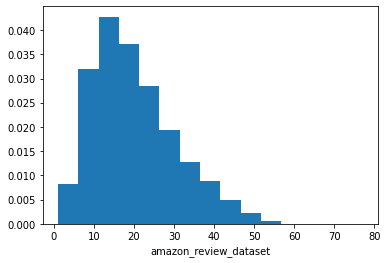

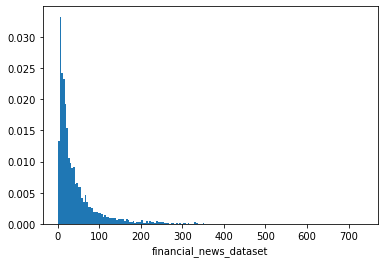

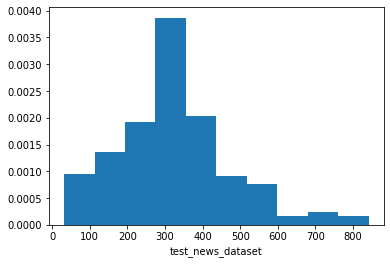

In [36]:
plot_data_length(amazon_review_train_dataset.sentence_lengths, "amazon_review_dataset", 1/5)
plot_data_length(financial_news_train_dataset.sentence_lengths, "financial_news_dataset", 1/4)
plot_data_length(test_dataset.sentence_lengths, "test_news_dataset", 1/80)


# Textfil på formatet data | label | datalängd

# for sentence_length in amazon_reviews.sentence_lengths: 15,17 % av denna. Använd divide_dataset_to_train_and_test
    # hitta rad i textfilen som har datalängd sentence length
        # annars kolla datalängd sentence_length-1 (upprepa tills ngt hittas)
    # ta bort den raden och lägg i separat textfil

# for sentence_length in financial_phrases.sentence_lengths:  #HELA DENNA
    # hitta rad i textfilen som har datalängd sentence length
        # annars kolla datalängd sentence_length-1 (upprepa tills ngt hittas)
    # ta bort den raden och lägg i separat textfil

# for sentence_length in own_collected_news.sentence_lengths: # HELA DENNA 
        # hitta rad i textfilen som har datalängd sentence length
        # annars kolla datalängd sentence_length-1 (upprepa tills ngt hittas)
    # ta bort den raden och lägg i separat textfil

plot label distribution

This is not being taken into consideration in the test now. We only look at the length distribution.

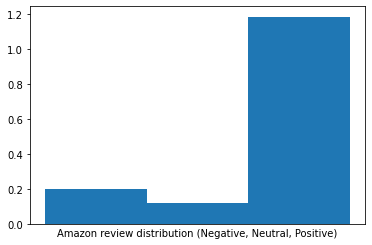

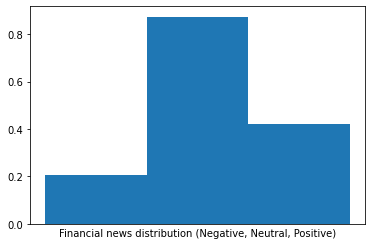

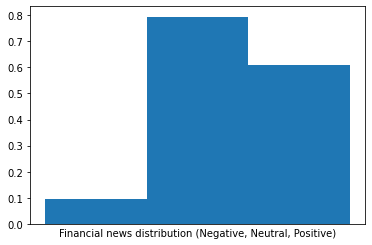

In [ ]:
plot_data_length(amazon_review_dataset.ys, "Amazon review distribution (Negative, Neutral, Positive)", 1.5, xparams=False)
plot_data_length(np.concatenate([financial_news_test_dataset.ys, financial_news_train_dataset.ys]), "Financial news distribution (Negative, Neutral, Positive)", 1.5, xparams=False)
plot_data_length(test_dataset.ys, "Financial news distribution (Negative, Neutral, Positive)", 1.5, xparams=False)

## Import swedish bert

In [26]:
tokenizer = BertTokenizer.from_pretrained('KB/bert-base-swedish-cased', do_lower_case=False)
bert = AutoModel.from_pretrained('KB/bert-base-swedish-cased')

Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenized = tokenizer(text=amazon_review_train_dataset[1][0], padding='longest', return_tensors='pt')
print(amazon_review_train_dataset[1][0])
print(tokenized.input_ids)
print(tokenized)

Jag  älskar  den  här  mattan  u  den  är  supersöt  och  sååå  mjuk  Den  är  faktiskt  större  än  jag  trodde  att  den  skulle  vara  Det  är  lätt  att  fälla  ihop  och  lägga  undan  och  det  är  lätt  att  rengöra  Jag  behöver  fler  av  dessa  till  mitt  hus  gt  _  lt  
tensor([[    2,   361,  4766,    97,   382, 21421,    56,    97,    54,  5096,
          7834, 49795,    36,   181, 49811, 49811,  7164,   219,    54,  2644,
           955,   390,   217,  3609,    48,    97,   409,   358,   160,    54,
          1048,    48, 17310,  2034,    36,  3329,  3424,    36,    82,    54,
          1048,    48, 19523, 16880,   361,  1404,  1448,    65,  1021,    76,
          1199,  1004,  2850,  3678,  5175,     3]])
{'input_ids': tensor([[    2,   361,  4766,    97,   382, 21421,    56,    97,    54,  5096,
          7834, 49795,    36,   181, 49811, 49811,  7164,   219,    54,  2644,
           955,   390,   217,  3609,    48,    97,   409,   358,   160,    54,
          1048,  

### Define colate function that tokenizes

In [19]:
def tensor_split(text1, seq_size=200, overlap=50, add_to_start = 2):
  l_total = []
  l_parcial = []
  cls_tokens = torch.unsqueeze(torch.as_tensor([add_to_start]* text1.shape[0]), dim=1)
  if text1.shape[1]//(seq_size-overlap) >0:
    n = text1.shape[1]//(seq_size-overlap)
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      # l_parcial = torch.concat([cls_tokens, text1[:,:seq_size]], dim=1)
      l_parcial = text1[:,:seq_size]
      l_total.append(l_parcial.to(device))
    else:
      # l_parcial = torch.concat([cls_tokens, text1[:,w*(seq_size-overlap):w*(seq_size-overlap) + seq_size]], dim=1)
      l_parcial = text1[:,w*(seq_size-overlap):w*(seq_size-overlap) + seq_size]
      l_total.append(l_parcial.to(device))
  return l_total

In [20]:
def our_collate_fn(data):
    x = [a[0] for a in data]
    y = [a[1] for a in data]
    tokenized = tokenizer(text=x, padding='longest', return_tensors='pt')

    return tokenized['input_ids'], torch.as_tensor(y), tokenized['attention_mask']

In [21]:
from torch.utils.data import DataLoader

def create_training_examples(dataset, batch_size = 64, seq_size = 200, overlap = 50):
    batch_sort_order = np.array_split(dataset.sentence_lengths.argsort()[::-1], round(len(dataset) / batch_size))
    tokenized_train_data = DataLoader(dataset, collate_fn=our_collate_fn, batch_sampler=batch_sort_order) #

    for bindex, (bx, by, ba) in enumerate(tokenized_train_data):
        yield tensor_split(bx, seq_size, overlap), tensor_split(ba, seq_size, overlap, add_to_start=1), by.to(device)
                




In [ ]:
import torch.nn as nn

rnn = nn.LSTM(10, 20, batch_first = True)
input = torch.randn(3, 5, 10)
h0 = torch.randn(1, 3, 20)
c0 = torch.randn(1, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

print("Input shape: {}".format([*input.shape]))
print("Output shape: {}".format([*output.shape]))
print("Last hidden state shape: {}".format([*hn.shape]))

Input shape: [3, 5, 10]
Output shape: [3, 5, 20]
Last hidden state shape: [1, 3, 20]


In [22]:
import torch.nn as nn
from sklearn import metrics


class DocBert(nn.Module):
    def __init__(self, bert, hidden_dim=20, num_labels=3):
        super().__init__()
        self.bert =  bert.to(device) # INTE BertForSequenceClassification
        self.lstm = nn.LSTM(bert.config.hidden_size, hidden_dim, batch_first=True).to(device)
        # Input [Batch_size, sequence_length, input_size]
        # Output [1, batch_size, hidden_dim]
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_dim, num_labels).to(device)
    
    def forward(self, x_seqs, a_seqs):
      output = []
      for x_seq, a_seq in zip(x_seqs, a_seqs):
        # print("x_seq, a_seq = {}, {}".format(x_seq, a_seq))
        output.append(self.bert(x_seq, a_seq)[0][:,0,:]) # Only get the embedding of the [CLS]-token [batch_size, number_of_sequences, input_size]
      # print(output)
      _ , (output, _) = self.lstm(torch.stack(output, dim=1)) # [1, batch_size, hidden_dim]
      output = self.relu(output)
      return self.linear(torch.squeeze(output, dim=0))
      #   bertified_seqs.append()
      # self.lstm(, )

    def predict(self, x_seq, a_seq):
      output = self.forward(x_seq, a_seq)
      # print("Output from forward: {}".format(output))
      batch_guess = torch.argmax(output, dim=1)
      return batch_guess

    def get_confusion_matrix(self, sequences, batch_size=8):
      predicted_tensor = torch.as_tensor([])
      correct_tensor = torch.as_tensor([])

      current_correct = 0
      
      current_tried = 0
      for x_seq, a_seq, by in create_training_examples(sequences, batch_size=batch_size):
        prediction = self.predict(x_seq, a_seq).to("cpu")
        # print("Prediction: {} \t Actual {}".format(*prediction, *by) )
        predicted_tensor = torch.concat((predicted_tensor, prediction))
        correct_tensor = torch.concat((correct_tensor, by.to("cpu")))
        # current_correct += torch.sum(prediction==by)
        # current_tried += batch_size
      confusion_matrix = metrics.confusion_matrix(correct_tensor.numpy(), predicted_tensor.numpy())
      


      return confusion_matrix

    def accuracy(self, sequences, batch_size=8):
      current_correct = 0
      
      current_tried = 0
      for x_seq, a_seq, by in create_training_examples(sequences, batch_size=batch_size):
        prediction = self.predict(x_seq, a_seq).to(device)
        # print("Prediction: {} \t Actual {}".format(*prediction, *by) )
        
        current_correct += torch.sum(prediction==by)
        current_tried += batch_size

      return current_correct / current_tried


#### Functions for training and testing a model

In [23]:
import torch.nn.functional as F
def train_docbert(pretrained_bert, dataset, hidden_dim=512, num_labels=3, epochs=1):
  docbert = DocBert(pretrained_bert, hidden_dim, num_labels)
  optimizer = torch.optim.Adam(docbert.parameters(), lr=2e-5) #lr based on docbert article
  for epoch in range(epochs):
    i = 0
    tot_loss = 0
    for x_seqs, a_seqs, by in create_training_examples(dataset, batch_size=8, seq_size=200, overlap=50):
      optimizer.zero_grad()
      preds = docbert.forward(x_seqs, a_seqs)
      loss = F.cross_entropy(preds, by)
      tot_loss += loss
      i += 1
      if i % 200 == 0:
        print(tot_loss / 200)
        tot_loss = 0
      loss.backward()
      optimizer.step()
    
  return docbert


def calc_opt_epoch_docbert(pretrained_bert, dataset, validation_dataset, hidden_dim=512, num_labels=3, max_epochs=50):
  docbert = DocBert(pretrained_bert, hidden_dim, num_labels)
  optimizer = torch.optim.Adam(docbert.parameters(), lr=2e-5) #lr based on docbert article
  last_accuracy = torch.as_tensor(0)
  for epoch in range(max_epochs):
    print("--- EPOCH {} ---".format(epoch))
    
    
    for x_seqs, a_seqs, by in create_training_examples(dataset, batch_size=8, seq_size=200, overlap=50):
      optimizer.zero_grad()
      preds = docbert.forward(x_seqs, a_seqs)
      loss = F.cross_entropy(preds, by)
      
      loss.backward()
      optimizer.step()
    accuracy = docbert.accuracy(validation_dataset, batch_size=1)
    print("current accuracy: {:.2f}".format(100*accuracy))
    # if torch.round(1000*accuracy) <= torch.round(1000*last_accuracy):
    #   return epoch-1
    last_accuracy = accuracy
  return max_epochs



In [34]:
def calc_from_conf_matrix(conf_matrix, label_names):
    col_sums = [0]*len(label_names)
    row_sums = []
    tot_sum = 0
    for rindex, row in enumerate(conf_matrix):
        col_sums += row
        row_sums.append(sum(row))
    tot_sum = sum(row_sums)

    accuracy = 0
    for i in range(len(label_names)):
         
        # precision
        precision = conf_matrix[i][i] / col_sums[i]
        print("Precision for {} is {:.2f}%".format(label_names[i], 100*precision))

        # recall
        recall = conf_matrix[i][i] / row_sums[i]
        print("Recall for {} is {:.2f}%".format(label_names[i], 100*recall))

        accuracy += conf_matrix[i][i]
    
    # accuracy
    print("Total accuracy is {:.2f}%".format(100*accuracy/tot_sum))


In [37]:
docbert_finance = train_docbert(bert, financial_news_train_dataset, epochs=25)

tensor(0.3310, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0585, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0643, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0310, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0453, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0238, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0315, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0111, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0087, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0182, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0168, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0197, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0157, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0111, device='cuda:0', grad_fn=<DivBack

In [27]:
docbert_amazon = train_docbert(bert, amazon_review_train_dataset, epochs=25)

tensor(0.3859, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2065, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1831, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1213, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0990, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1336, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0689, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0684, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0933, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0414, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0457, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0685, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0294, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0291, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0359, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0250, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0275, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0421, device='cuda:0', grad_fn=<DivBack

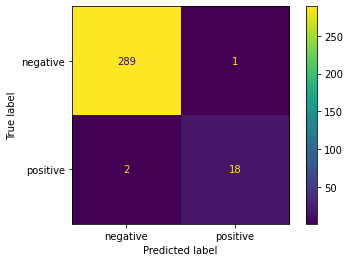

In [31]:
import matplotlib.pyplot as plt


conf_m_amazon = docbert_amazon.get_confusion_matrix(test_dataset, batch_size=1)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_m_amazon, display_labels = ["negative", "positive"])
cm_display.plot()

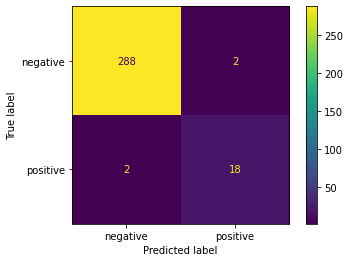

In [38]:
import matplotlib.pyplot as plt


conf_m_finance = docbert_finance.get_confusion_matrix(test_dataset, batch_size=1)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_m_finance, display_labels = ["negative", "positive"])
cm_display.plot()

In [39]:
print(conf_m_amazon)
calc_from_conf_matrix(conf_m_amazon, ["Negative", "Positive"])


[[289   1]
 [  2  18]]
Precision for Negative is 99.31%
Recall for Negative is 99.66%
Precision for Positive is 94.74%
Recall for Positive is 90.00%
Total accuracy is 99.03%


In [40]:
print(conf_m_finance)
calc_from_conf_matrix(conf_m_finance, ["Negative", "Positive"])

[[288   2]
 [  2  18]]
Precision for Negative is 99.31%
Recall for Negative is 99.31%
Precision for Positive is 90.00%
Recall for Positive is 90.00%
Total accuracy is 98.71%


# Money calculations
Given that all money is invested at every purchase, this is the percentage gain after buying every stock which the model predicted as positive.

* A true positive news corresponds to a 4.9% increase in stock price.

* A true negative news corresponds to a 5.1% decrease in stock price.

* A true neutral news corresponds to a 0.1% decrease due to brokerage.

In [ ]:
def calc_winnings(conf_matrix):
    return 0.949**conf_matrix[0][2] * 0.99**conf_matrix[1][2] * 1.051**conf_matrix[2][2]

In [ ]:
winning_factor = calc_winnings(conf_m)
start_capital = 10000

print("By investing {} SEK, we would mulitply our initial investment by {:.3f}, thus having {:.0f} SEK".format(start_capital, winning_factor, start_capital*winning_factor))

By investing 10000 SEK, we would mulitply our initial investment by 3.004, thus having 30044 SEK


## Train and save the financial model

## Load the financial model and evaluate it on similar test-data 
accuracy should be 88%+